In [50]:
source('~/Code/R_preamble/preamble.R')

# Growth rate

In [51]:
# Pool data from alpha and gamma
# Beta is bad because there was not enough exponential warmup time

gr = rbind(
    read.tsv('group_params_BC_alpha.tsv')
    )

gr_sum =
gr %>%
    group_by(strain) %>%
    summarise(
        tau_mean = mean(tau), tau_min = mean(tau) - sd(tau), tau_max = mean(tau) + sd(tau),
        tau_lab = paste(round(median(tau),1), sep = '±')
    )

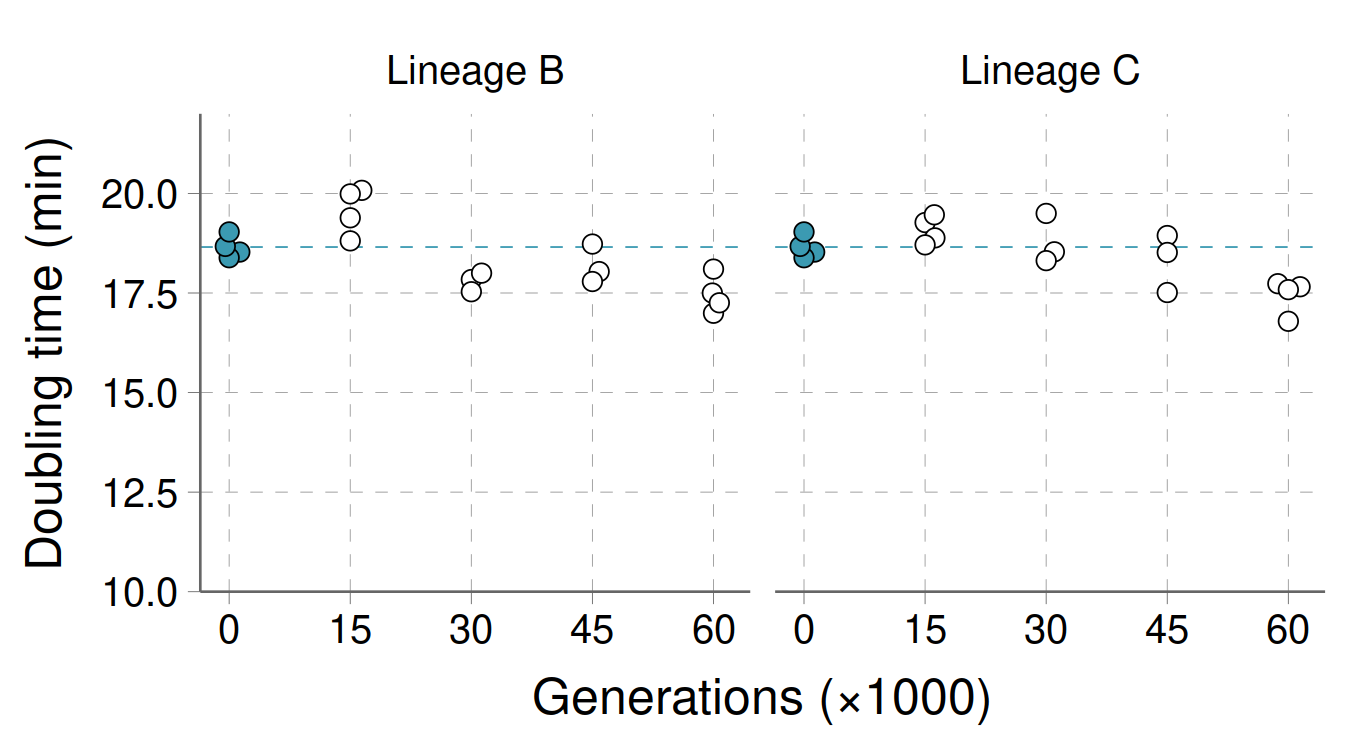

In [52]:
size(2.5, 4.5)

wt_color = pal[1]
ev_color = w

ggplot() +
    aes(x = gen * 2.5, y = tau) +

    ycont(10, 22) +

    #geom_rect(data = gr_sum %>% filter(strain == 'WT'), col = NA, alpha = 0.1, xmin = 0, xmax = 10, aes(ymin = tau_min, ymax = tau_max), fill = wt_color) +
    geom_hline(data = gr_sum %>% filter(strain == 'WT') %>% select(-strain), aes(yintercept = tau_mean), col = wt_color, lty = 2, lwd = 0.2) +

    facet_grid(~paste('Lineage', strain)) +

    scale_x_continuous(breaks = 2.5*seq(0, 60, 6)) +

    geom_beeswarm(
        data = gr %>% filter(strain != 'WT'),
        cex = 2.5, pch = 21, size = 2, stroke = 0.3, fill = ev_color
    ) +

    geom_beeswarm(
        data = gr %>% filter(strain == 'WT') %>% select(-strain),
        cex = 2.5, pch = 21, size = 2, stroke = 0.3, fill = wt_color
    ) +

    # geom_text(
    #     data = gr_sum,
    #     aes(y = tau_min, label = tau_lab), 
    #     nudge_y = -1.3, size = 2.7
    #     ) +

    labs(x = 'Generations (×1000)', y = 'Doubling time (min)')

psave('Plots/growth_rates')

# Growth dynamics
(gamma only)

In [53]:
d = read.tsv('growth_dynamics_BC_alpha.tsv')

In [54]:
library(stats)

# Simple spline-based GCV smoothing function
smooth_spline <- function(x, y, df) {

  # Sort by time to ensure proper interpolation
  ord <- order(x)
  x <- x[ord]
  y <- y[ord]
  
  # Perform spline interpolation
  fit <- smooth.spline(
    x = x,
    y = y,
    df = df
  )

  return(predict(fit, x = x)$y)
}

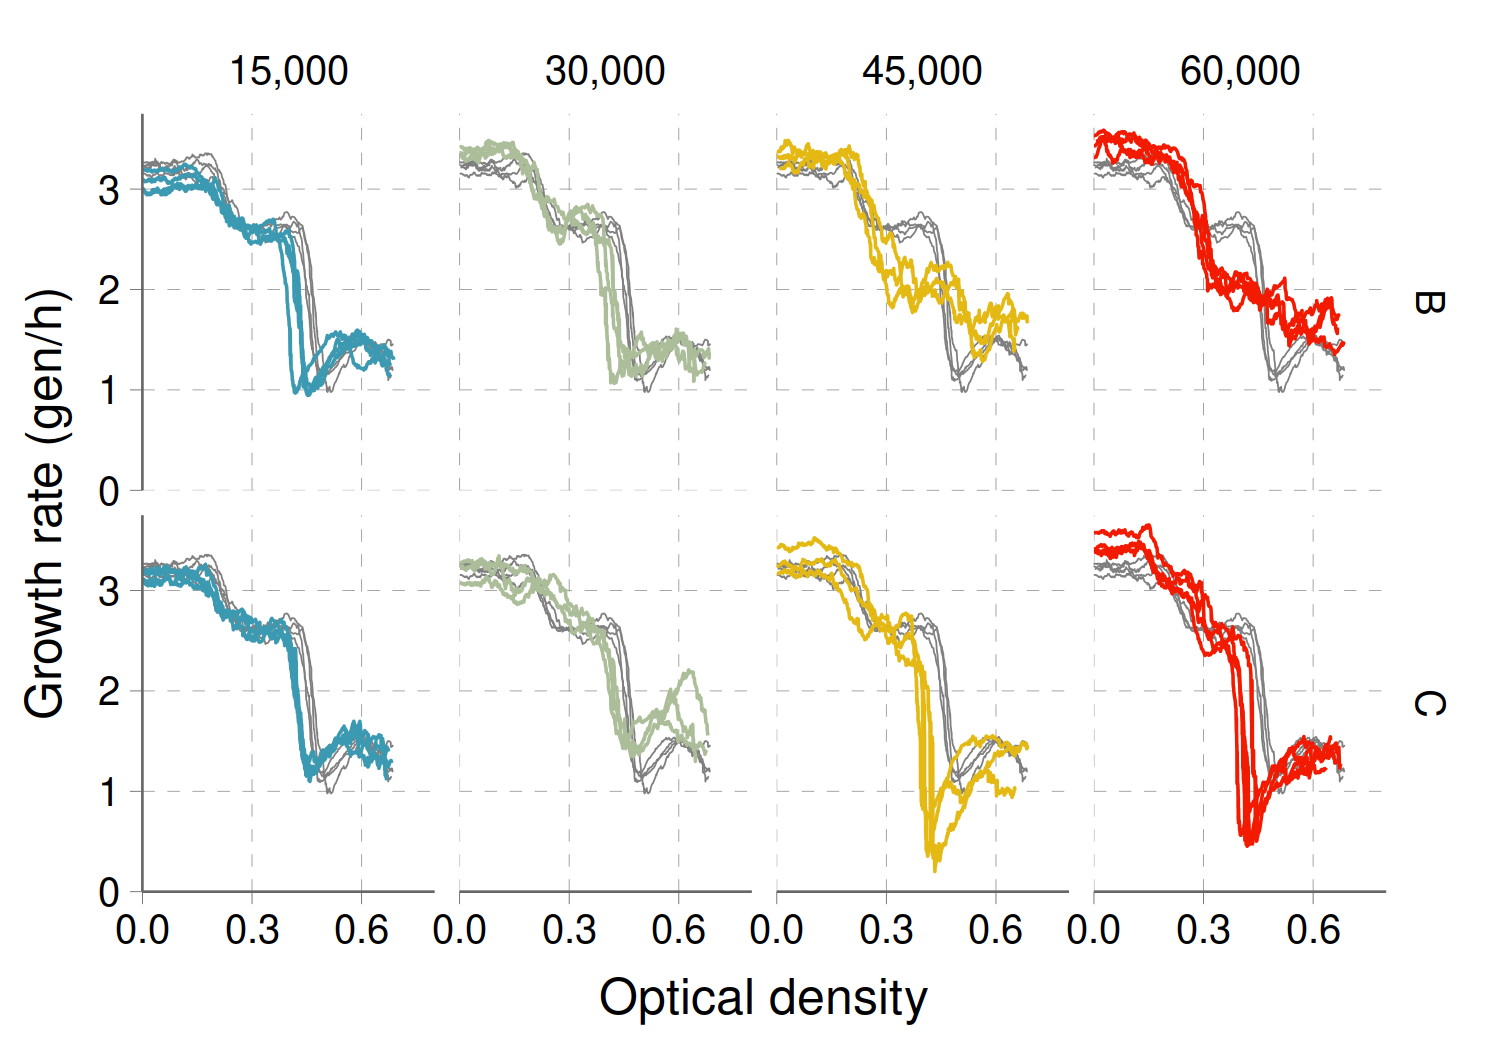

In [57]:
lwd = 0.4
lwd_wt = 0.2

wt_color = 'grey50'

max_od = 0.8

size(3.5, 5)

df = 50 # degrees of freedom for smoothing

d_smooth =
d %>%
    arrange(well, o_filt) %>% 

    group_by(well, rep) %>%
    mutate(
        gr_filt = 60/tau_filt,
        gr_smooth = smooth_spline(o_filt, gr_filt, df)
        ) %>%
    ungroup()

d_trim = d_smooth %>% filter(o_filt <= max_od)

d_trim %>%
    filter(strain != 'WT') %>% 
    mutate(genk = paste0(gen * 2.5, ',000')) %>% 

ggplot() + aes(o_filt, gr_filt, col = gen, group = paste(well, rep)) +
    nl +
    facet_grid(strain ~ genk) +
    xcont(NA, max_od, breaks = seq(0, 0.6, 0.3)) + 
    ycont(0, 3.75, breaks = seq(0, 3, 1)) +

    geom_line(data = d_trim %>% filter(strain == 'WT') %>% select(-strain, -gen), col = wt_color, lwd = lwd_wt) +
    geom_line(lwd = lwd) +

    #annotate(geom = 'text', x = 0.1, y = 3.05, label = 'WT', size = 3.5, fontface = 'bold', col = b) +
    #annotate(geom = 'text', x = 0.27, y = 3.6, label = '60k', size = 3.5, fontface = 'bold', col = pal[2]) +

    labs(x = 'Optical density', y = 'Growth rate (gen/h)')

psave('Plots/growth_rate_vs_od')

# Pooled version

`summarise()` has grouped output by 'strain', 'gen'. You can override using the `.groups` argument.


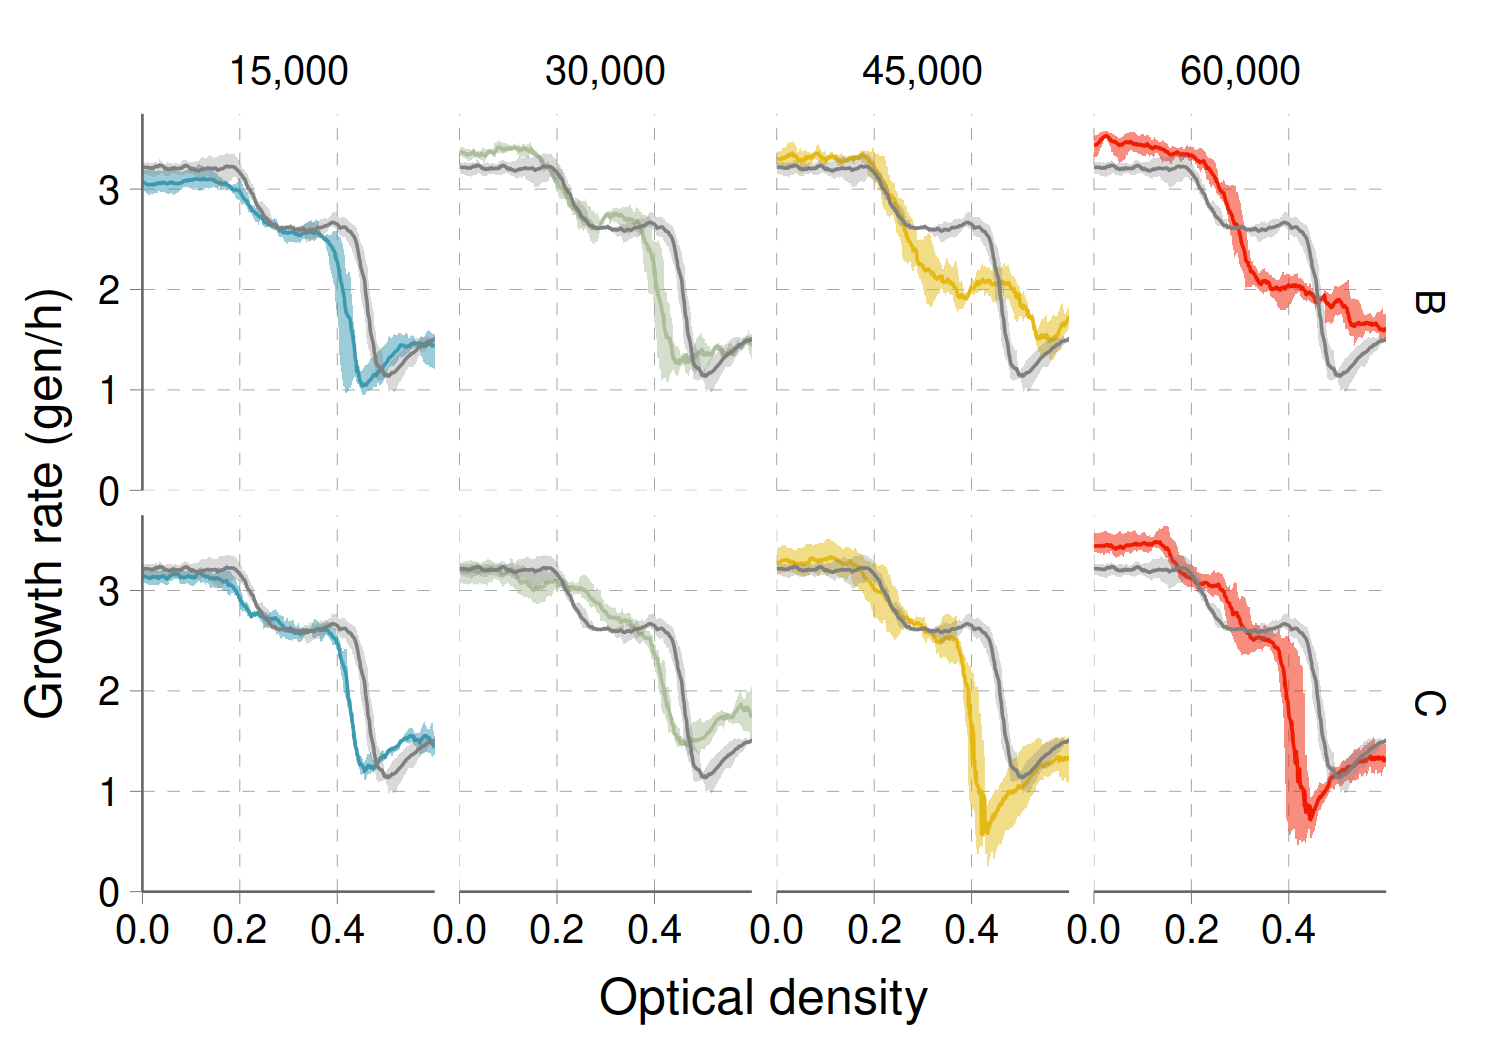

In [58]:
max_od = 0.6
resolution = 1e-4

d_interp =
d %>% 
    mutate(gr_filt = 60/tau_filt) %>% 

    group_by(well, name, strain, gen, rep) %>%
    group_modify(~{
        o_smooth <- seq(0, max_od, by = resolution)
        interp_values <- approx(
          x = .x$o_filt,
          y = .x$gr_filt,
          xout = o_smooth,
          method = "linear",
          rule = 2  # extrapolate if needed
        )
        data.frame(
          o_smooth = interp_values$x,
          gr_smooth = interp_values$y
        )
      }) %>%
    ungroup() 

d_sum =
d_interp %>% 
    group_by(strain, gen, o_smooth) %>%
    summarise(
        m = mean(gr_smooth),
        s = sd(gr_smooth),
        mn = min(gr_smooth), mx = max(gr_smooth)
        ) %>%
    ungroup()

ribbon_alpha = 0.5
ribbon_alpha_wt = 0.3

lwd = 0.4
lwd_wt = 0.4

size(3.5, 5)

d_sum %>% 
    filter(strain != 'WT', strain != 'E') %>% 
    mutate(genk = paste0(gen * 2.5, ',000')) %>% 

ggplot() + aes(o_smooth, 
               m, ymin = mn, ymax = mx,
               #ymin = m - s, ymax = m + s,
               col = gen,
               ) +
    nl +
    facet_grid(strain ~ genk) +

    xcont(0, max_od, breaks = seq(0, 0.5, 0.2)) + ycont(0, 3.75, breaks = seq(0, 3, 1)) +

    geom_ribbon(col = NA, alpha = ribbon_alpha, aes(fill = gen)) +
    geom_line(lwd = lwd) +

    geom_ribbon(data = d_sum %>% filter(strain == 'WT') %>% select(-strain, -gen), col = NA, fill = wt_color, alpha = ribbon_alpha_wt) +
    geom_line(data = d_sum %>% filter(strain == 'WT') %>% select(-strain, -gen), col = wt_color, lwd = lwd_wt) +

    #annotate(geom = 'text', x = 0.19, y = 2.7, label = 'WT', size = 3, fontface = 'bold', col = wt_color) +
    #annotate(geom = 'text', x = 0.35, y = 3.1, label = '60k', size = 3, fontface = 'bold', col = pal[2]) +

    labs(x = 'Optical density', y = 'Growth rate (gen/h)')

psave('Plots/growth_rate_vs_od_pooled')